# Melt thermometers

In this notebook we benchmark MagmaPandas codes for melt-only thermometers by reproducing calculations and/or figures from literature. When possible, we compare MagmaPandas results to results from codes or data provided with the original publication of the model. Unfortunately, in many cases these are not available, in which case we've compiled the input data ourselves. In these cases, we cannot be 100% sure that we use exacly the same input data and small differences between MagmaPandas results and data in published figures are expected.

In [1]:
import MagmaPandas as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geoplot as gp
import Thermobar as tb

from MagmaPandas.model_calibrations import get_calibration_data
from MagmaPandas.tools.modify_compositions import _remove_elements

mm = 1 / 25.4

### Putirka (2008), eqs. 13-16 and 22 

We benchmark the models from {cite:t}`Putirka2008a` by comparing our temperatures with those calculated with the excelsheet available on [Putirka's personal website](https://sites.google.com/mail.fresnostate.edu/keithputirka/home). For eq. 22 we use D(Mg) calculated from Beattie.

As input data we use the Sun Fe3Fe2 calibration database, as this includes a wide range of (hydrous) compositions. Note that the putirka thermometers have not been calibrated for some of these compositions, so the calculated temperatures are not neccessarily realistic. However, for benchmarking that is not important, as we're only demonstrating that MagmaPandas results match those of the putrika excelsheet.



In [2]:
putirka_temperatures = pd.read_csv("./data/melt_thermometers/melt_thermometer_putirka2008.csv")
calibration_sun = get_calibration_data(parameter="Kd", model="sun2020").set_index("run", drop=True)

# only use the elements included in the excel sheet
elements = ["SiO2", "TiO2", "Al2O3", "FeO", "MnO", "MgO", "CaO", "Na2O", "K2O", "H2O"]
compositions = mp.Melt(calibration_sun.loc[:,elements], units="wt. %", datatype="oxide")

In [3]:
thermometers = [f"putirka2008_{i}" for i in (13, 14, 15, 16, 22)]
T_K_predict = pd.DataFrame(index=compositions.index, columns=thermometers)

for thermometer in thermometers:
    mp.configuration.melt_thermometer = thermometer

    T_K_predict[thermometer] = compositions.temperature(P_bar=calibration_sun["P_bar"])

/Users/thomas/Dropbox/research/python/packages/MagmaPandas/src/MagmaPandas/tools/calibration_range.py:36: UserWarning: samples ('M172', 'M165', 'M265', 'M278', 'M282', 'M289', 'M295', 'A471', 'A472', 'A482', 'A500', 'A483', 'A486', 'M363', 'M343', 'od109', 'od109', 'od108', 'od108', 'od111', 'od111', 'od103', 'od103', 'od101', 'od101', 'od102', 'od102', 'od110', 'od110', 'od107', 'od107', 'od104', 'od104', 'G217', 'G227', 'JER15-63', 'JER15-51', 'JER16-74', 'JER15-57', 'JER15-60', 'JER16-75', 'JER15-73', 'JER15-62', 'JER15-68', 'JER15-43', 'JER15-48', 'JER15-53', 'JER15-54', 'JER15-37', 'JER15-39', 'JER15-67', 'JER15-65', 'JER15-64', 'JER15-55', 'JER15-69', 'JER15-61', 'JER15-59', 'JER15-56', 'JER15-36', 'MA165', 'MA166', 'MA167', 'MA180', 'MA181', 'MA185', 'MA190', 'MA192', 'MA193', 'MA200') have compositions outside the thermometer calibration range
  w.warn(
/Users/thomas/Dropbox/research/python/packages/MagmaPandas/src/MagmaPandas/tools/calibration_range.py:36: UserWarning: samples

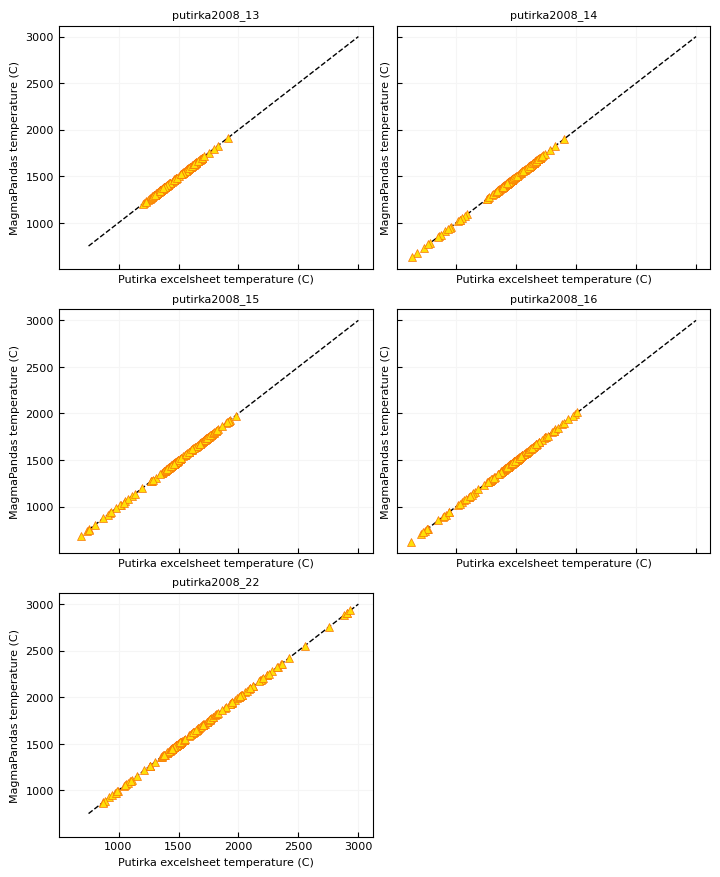

In [4]:
mm = 1 / 25.4
gp.layout(colors=gp.colors.bright)

limits = np.array([750, 3000])

fig, axs = plt.subplots(3, 2, figsize=(180 * mm, 220 * mm), sharex=True, sharey=True)

for thermometer, ax in zip(thermometers, axs.flatten()):
    ax.plot(limits, limits, "--", c="k")
    ax.plot(putirka_temperatures[thermometer], T_K_predict[thermometer]-273.15, lw=0., ms=6)

    ax.set_xlabel("Putirka excelsheet temperature (C)")
    ax.set_ylabel("MagmaPandas temperature (C)") 
    ax.set_title(thermometer)   

axs.flatten()[-1].axis("off")

plt.show()

### Sun et al. (2020)

{cite:t}`Sun2020a` provide an excelsheet to calculate temperatuers with their equation 6. We compare magmapandas results to those from the excelsheet. As input data we use their calibration dataset. This dataset is also used to calibrate their olivine-melt Fe-Mg Kd model.

In [5]:
sun_file = "./data/melt_thermometers/melt_thermometer_sun2020.csv"
temperatures_sun = pd.read_csv(sun_file, index_col=[0])
P_bar = temperatures_sun["P_bar"]

calibration_sun = get_calibration_data(parameter="Kd", model="sun2020").set_index(
    "run", drop=True
)

# only use the elements included in the excel sheet
elements = [
    "SiO2",
    "TiO2",
    "Al2O3",
    "Cr2O3",
    "FeO",
    "MnO",
    "MgO",
    "CaO",
    "Na2O",
    "K2O",
    "P2O5",
    "NiO",
    "H2O",
    "CO2",
]
compositions_sun = mp.Melt(
    calibration_sun.loc[:, elements], units="wt. %", datatype="oxide"
)

In [6]:
mp.configuration.melt_thermometer = "sun2020"

temperatures_sun_magmapandas = compositions_sun.temperature(P_bar=P_bar)

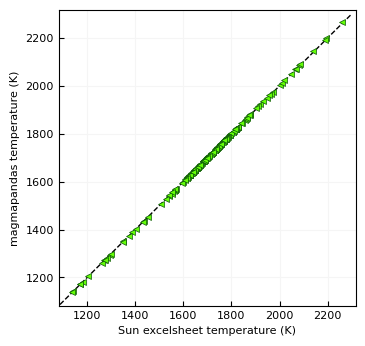

In [7]:
mm = 1 / 25.4
gp.layout(colors=gp.colors.bright)

limits = np.array([900, 2000])

fig, ax = plt.subplots(figsize=(90 * mm, 85 * mm))

ax.plot(temperatures_sun["T_K"], temperatures_sun_magmapandas, lw=0., zorder=10)
limits = ax.get_xlim()
ax.plot((1000, 2300), (1000, 2300), "--", c="k", zorder=1)

ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.set_xlabel("Sun excelsheet temperature (K)")
ax.set_ylabel("magmapandas temperature (K)")


plt.show()

### Shea et al. (2022)

Eq. 1 from {cite:t}`Shea2022` is 

T(C) = 21.2 × MgO(wt.%) + 1017

This is a very straightforward equation that requires not data conversion (moles, cation) or other processing. We are therefore confident that our implementation is correct and have not performed validation tests.

### Sugawara et al. (2000)

Calibration data for eqs. 3 and 6a from {cite:t}`Sugawara2000` are not available and figures from the paper therefore can't be reproduced. Instead, we compare our results with those from the implementations in Thermobar by {cite:t}`Wieser2022`. 

Thermobar doesn't process CO2, so we remove those concentrations. The thermobar implementation of eq. 3 does not include the H2O correction and we therefore removed H2O from the compositions for calculations using this model.

As input data we se the calibration dataset of the Kd model by {cite:t}`Sun2020a` because it includes a wide range of (hydrous) melt compositions.

In [8]:
compositions_sugawara_thermobar = get_calibration_data(parameter="Kd", model="sun2020")
compositions_sugawara_thermobar = compositions_sugawara_thermobar.drop(columns=["CO2"])
P_bar = compositions_sugawara_thermobar["P_bar"]


compositions_sugawara_magmapandas = mp.Melt(compositions_sugawara_thermobar.iloc[:,2:17], datatype="oxide", units="wt. %")

compositions_sugawara_thermobar = compositions_sugawara_thermobar.iloc[:,2:17]
compositions_sugawara_thermobar.columns = [f"{col}_Liq" for col in compositions_sugawara_thermobar.columns]
compositions_sugawara_thermobar = compositions_sugawara_thermobar.rename(columns={"FeO_Liq": "FeOt_Liq"})

In [9]:
T_K_sugawara_thermobar = pd.DataFrame(
    index=compositions_sugawara_thermobar.index, columns=("sugawara2000_3", "sugawara2000_6a")
)

T_K_sugawara_thermobar["sugawara2000_3"] = tb.calculate_liq_only_temp(
    liq_comps=compositions_sugawara_thermobar.drop(columns=["H2O_Liq"]),
    equationT="T_Sug2000_eq3_ol",
    P=P_bar / 1e3,
)
T_K_sugawara_thermobar["sugawara2000_6a"] = tb.calculate_liq_only_temp(
    liq_comps=compositions_sugawara_thermobar, equationT="T_Sug2000_eq6a_H7a", P=P_bar / 1e3
)

In [10]:
T_K_sugawara_magmapandas = pd.DataFrame(
    index=compositions_sugawara_thermobar.index, columns=("sugawara2000_3", "sugawara2000_6a")
)

mp.configuration.melt_thermometer = "sugawara2000_3"
T_K_sugawara_magmapandas["sugawara2000_3"] = (
    compositions_sugawara_magmapandas.drop(columns=["H2O"])
    .recalculate()
    .temperature(P_bar=P_bar)
)
mp.configuration.melt_thermometer = "sugawara2000_6a"
T_K_sugawara_magmapandas["sugawara2000_6a"] = compositions_sugawara_magmapandas.temperature(P_bar=P_bar)

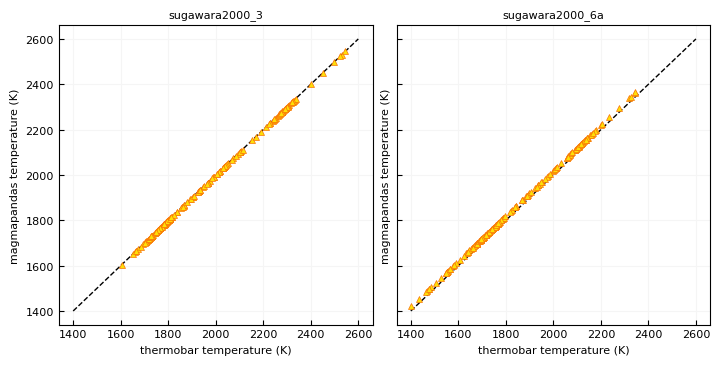

In [13]:
mm = 1 / 25.4
gp.layout(colors=gp.colors.bright)

limits = np.array([1400, 2600])

fig, axs = plt.subplots(1, 2, figsize=(180 * mm, 90 * mm), sharex=True, sharey=True)

for (thermometer, series), ax in zip(T_K_sugawara_thermobar.items(), axs):

    ax.plot(limits, limits, "--", c="k")
    ax.plot(series, T_K_sugawara_magmapandas[thermometer], lw=0.)

    ax.set_title(thermometer)
    ax.set_xlabel("thermobar temperature (K)")
    ax.set_ylabel("magmapandas temperature (K)")


plt.show()